# Map visualizations and geographic analysis

In [1]:
# imports and setup
from   adjustText import adjust_text
from   ast import literal_eval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   collections import Counter, defaultdict
import fightinwords as fw
from   itertools import pairwise
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import string
from   unidecode import unidecode
import warnings

data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
fig_dir = os.path.join('..', 'figures')

conlit_input_file = 'conlit.csv.gz'
early_input_file = 'early.csv.gz'

# settings
vis_formats = [
    'png',
    'svg',
]
map_alpha = 0.15

## CONLIT

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_input_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit = conlit.fillna('')
conlit.replace([np.inf, -np.inf], np.nan, inplace=True)
conlit.rename(columns={'source':'collection'}, inplace=True)
conlit.loc[conlit.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

### Geo data for CONLIT

In [3]:
# regularize data to wilkens geo format
punctuation_to_space = str.maketrans({key:' ' for key in string.punctuation})

def regularize_string(place_string):
    return(unidecode(' '.join(place_string.translate(punctuation_to_space).lower().split())))

wi = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wi = wi.loc[wi.lang=='en']
wi.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'
hand.loc['baltic', ['ignore', 'alias_to']] = [0, 'baltic sea']

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (~hand.ignore.equals(1)) & (hand.alias_to.isin(wi.index)), 'alias_to'].items():
    wi.loc[original_place] = wi.loc[alias_to]
    
# drop ignored places
wi.drop(hand.loc[hand.ignore==1].index, inplace=True, errors='ignore')

In [4]:
# drop unused places
wi_gpes = Counter()
for sequence in conlit.gpe_sequences:
    wi_gpes.update([regularize_string(i) for i in sequence])
wi.drop(wi.loc[~wi.index.isin(wi_gpes)].index, inplace=True, errors='ignore')

### CONLIT mapping

In [5]:
def get_lat_lon(place_string, geo_data=wi, extended=False):
    '''Assumes lookup string has been regularized if necessary'''
    try:
        if extended:
            return(geo_data.loc[place_string, ['lat', 'lon', 'country_short', 'admin_1_std', 'location_type']])
        else:
            return(geo_data.loc[place_string, ['lat', 'lon']])
    except (ValueError, KeyError):
        return(None)

def get_hops(list_of_places, geo_data=wi):
    '''Takes a list of locations, returns a list of origin-destination lat/lon tuples'''
    hop_list = []
    seq = [regularize_string(i) for i in list_of_places if regularize_string(i) in geo_data.index]
    for location1, location2 in pairwise(seq):
        loc1 = get_lat_lon(location1, geo_data, extended=True)
        loc2 = get_lat_lon(location2, geo_data, extended=True)
        if loc1 is None or loc2 is None: pass # should never happen, but check
        elif loc1.equals(loc2): pass # ignore identical places, even if called different names
        # eliminate place -> higher-order place in same admin area
        elif (loc1.location_type=='country' or loc2.location_type=='country') and \
           (loc2.country_short==loc1.country_short): pass
        elif (loc1.location_type=='administrative_area_level_1' or \
              loc2.location_type=='administrative_area_level_1') and \
             (loc2.country_short==loc1.country_short and \
              loc2.admin_1_std==loc1.admin_1_std): pass
        else:
            loc1 = tuple(loc1[['lat', 'lon']])
            loc2 = tuple(loc2[['lat', 'lon']])   
            hop_list.append((loc1, loc2))
    return(hop_list)

In [6]:
# get lat/lon data for all hops in all books
conlit_hops = conlit.gpe_sequences.apply(get_hops)

conlit_hops_counter = Counter()
for book in conlit_hops:
    for pair in book:
        hop = sorted(pair)
        conlit_hops_counter[tuple(hop)] += 1

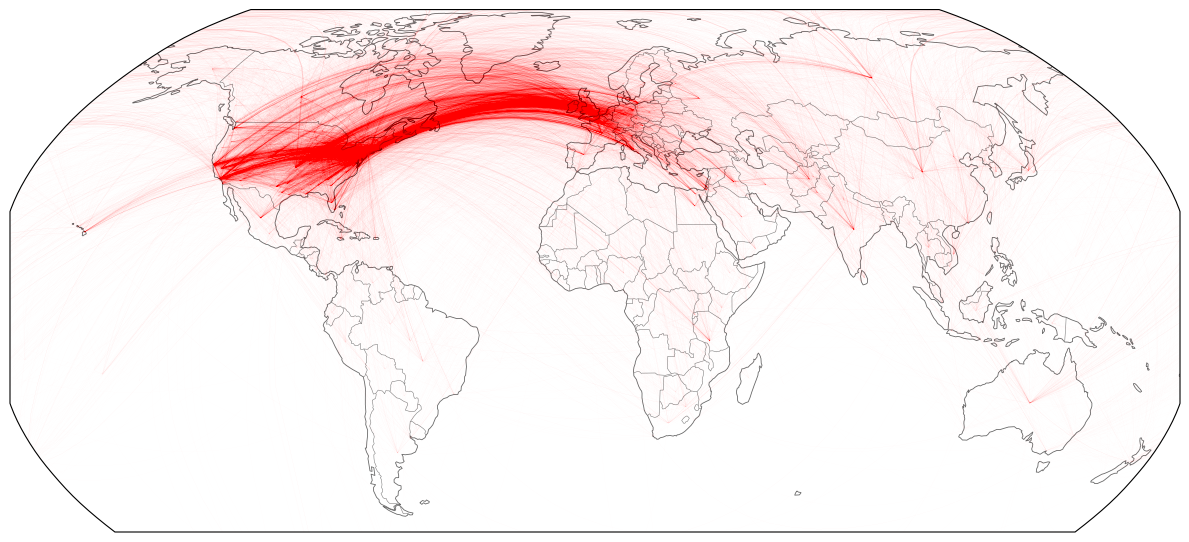

CPU times: user 44.1 s, sys: 187 ms, total: 44.3 s
Wall time: 44.5 s


In [7]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-175, 175, -60, 85])
sizefactor = 1000/conlit_hops_counter.total()
for hop in conlit_hops_counter:
    plt.plot(
        [i[1] for i in hop],
        [i[0] for i in hop], 
        color='red', 
        marker=None, 
        alpha=map_alpha, 
        linewidth=conlit_hops_counter[hop]*sizefactor,
        transform=ccrs.Geodetic()
    )
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
fig.canvas.draw()
plt.tight_layout()
for ext in vis_formats:
    plt.savefig(
        os.path.join(
            fig_dir, 
            'maps', 
            'world_hop_map_CONLIT.'+ext
        ), 
        dpi=300
    )
plt.show()

In [8]:
print(f'Total CONLIT hops: {conlit_hops_counter.total()}')

Total CONLIT hops: 79899


## EARLY

In [9]:
early = pd.read_csv(
    os.path.join(derived_dir, early_input_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early = early.fillna('')
early.replace([np.inf, -np.inf], np.nan, inplace=True)
early.loc[early.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

### Geo data for EARLY

In [10]:
# reread geo data to retain relevant locations, etc.
wie = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wie = wie.loc[wie.lang=='en']
wie.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'
hand.loc['baltic', ['ignore', 'alias_to']] = [0, 'baltic sea']

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (~hand.ignore.equals(1)) & (hand.alias_to.isin(wie.index)), 'alias_to'].items():
    wie.loc[original_place] = wie.loc[alias_to]

# drop ignored places
wie = wie.drop(hand.loc[hand.ignore==1].index, errors='ignore')

# drop unused places
wie_gpes = Counter()
for sequence in early.gpe_sequences:
    wie_gpes.update([regularize_string(i) for i in sequence])
wie.drop(wie.loc[~wie.index.isin(wie_gpes)].index, inplace=True, errors='ignore')

In [11]:
# drop unused places
wie_gpes = Counter()
for sequence in early.gpe_sequences:
    wie_gpes.update([regularize_string(i) for i in sequence])
wie.drop(wie.loc[~wie.index.isin(wie_gpes)].index, inplace=True, errors='ignore')

### EARLY mapping

In [12]:
# get lat/lon data for all hops in all books
early_hops = early.gpe_sequences.apply(get_hops, {'geo_data':wie})

early_hops_counter = Counter()
for book in early_hops:
    for pair in book:
        hop = sorted(pair)
        early_hops_counter[tuple(hop)] += 1

/var/folders/7w/9w42413d6yq9tdnnb2kd8wgc0000gn/T/ipykernel_26257/1350954246.py:2: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  early_hops = early.gpe_sequences.apply(get_hops, {'geo_data':wie})


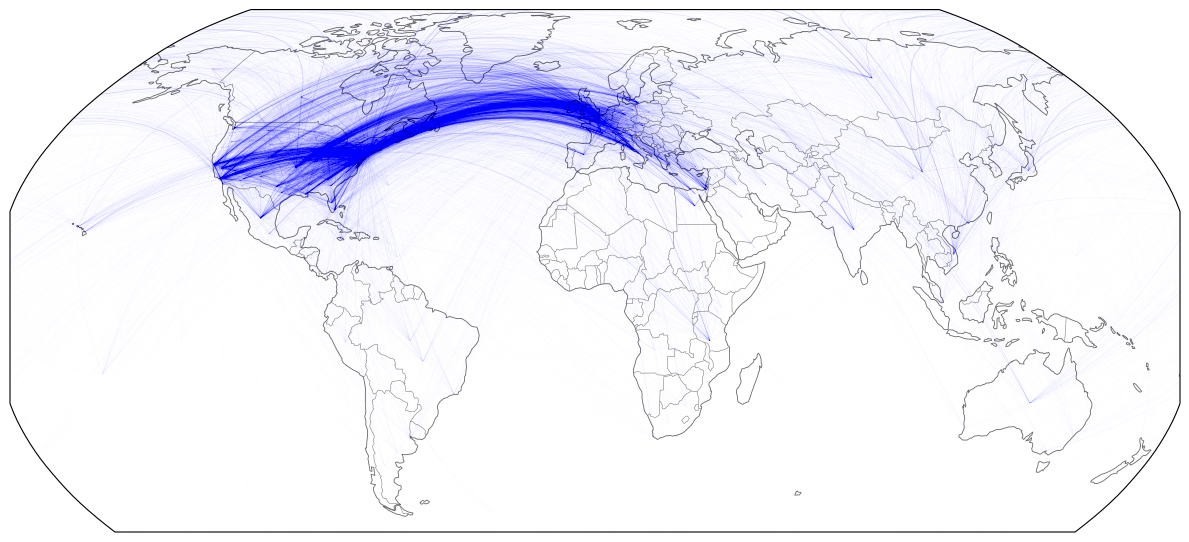

CPU times: user 49.4 s, sys: 225 ms, total: 49.6 s
Wall time: 49.7 s


In [13]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-175, 175, -60, 85])
sizefactor = 1000/early_hops_counter.total()
for hop in early_hops_counter:
    plt.plot(
        [i[1] for i in hop],
        [i[0] for i in hop], 
        color='blue', 
        marker=None, 
        alpha=map_alpha, 
        linewidth=early_hops_counter[hop]*sizefactor,
        transform=ccrs.Geodetic()
    )
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
fig.canvas.draw()
plt.tight_layout()
for ext in vis_formats:
    plt.savefig(
        os.path.join(
            fig_dir, 
            'maps', 
            'world_hop_map_EARLY.'+ext
        ), 
        dpi=300
    )
plt.show()

In [14]:
print(f'Total EARLY hops: {early_hops_counter.total()}')

Total EARLY hops: 113581


## Combined

In [15]:
all_hops_counter = early_hops_counter + conlit_hops_counter
print(f'Total combined hops: {all_hops_counter.total()}')

Total combined hops: 193480


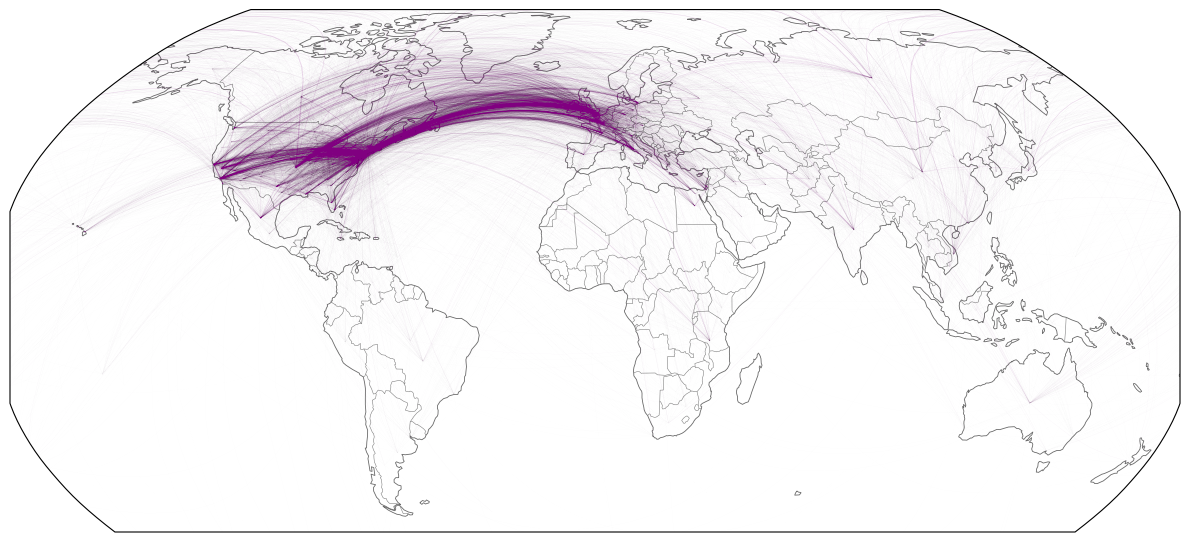

In [16]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-175, 175, -60, 85])
sizefactor = 1000/all_hops_counter.total()
for hop in all_hops_counter:
    plt.plot(
        [i[1] for i in hop],
        [i[0] for i in hop], 
        color='purple', 
        marker=None, 
        alpha=map_alpha, 
        linewidth=all_hops_counter[hop]*sizefactor,
        transform=ccrs.Geodetic()
    )
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
fig.canvas.draw()
plt.tight_layout()
for ext in vis_formats:
    plt.savefig(
        os.path.join(
            fig_dir, 
            'maps', 
            'world_hop_map_ALL.'+ext
        ), 
        dpi=300
    )
plt.show()

## Subset by collection or date range

In [18]:
# read full dataset from disk
data = pd.read_csv(
    os.path.join(derived_dir, 'all.csv.gz'),
    index_col='book_id',
    converters={
    'gpe_places': string_to_list,
    'nongpe_places': string_to_list,
    'all_places': string_to_list,
    'gpe_sequences': string_to_list
    }
)

In [19]:
# set colors for subcorpora
prop_cycle = plt.rcParams['axes.prop_cycle']
color_list = prop_cycle.by_key()['color']
colors = {}
for i, subcorpus in enumerate(data.collection.unique()):
    colors[subcorpus] = color_list[i]

### By subcorpus

Total hops in chicago_1: 18594 (from 2608 volumes)


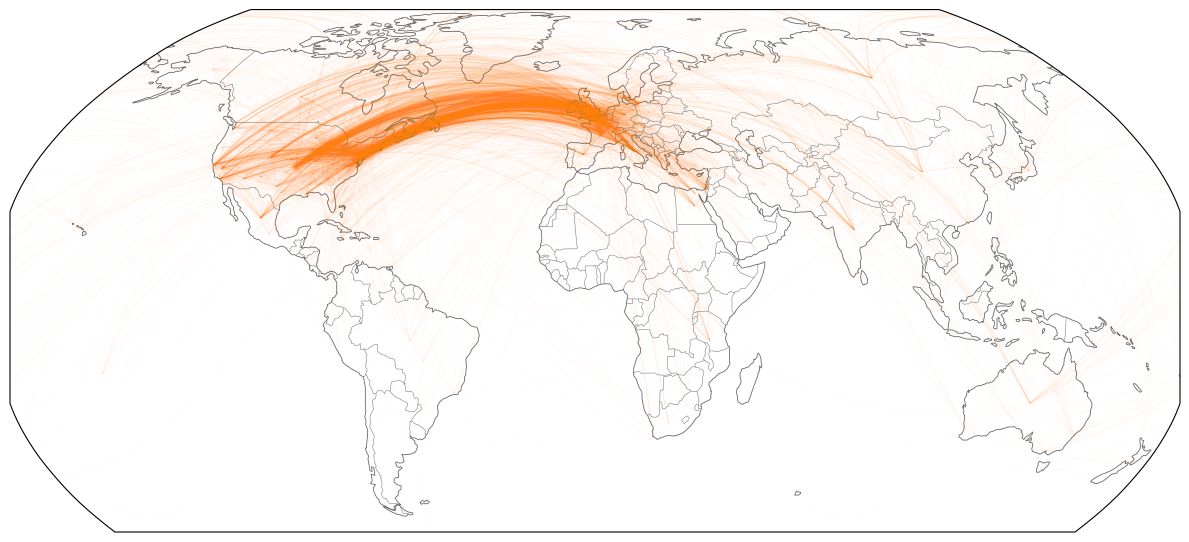

Total hops in chicago_2: 88565 (from 6481 volumes)


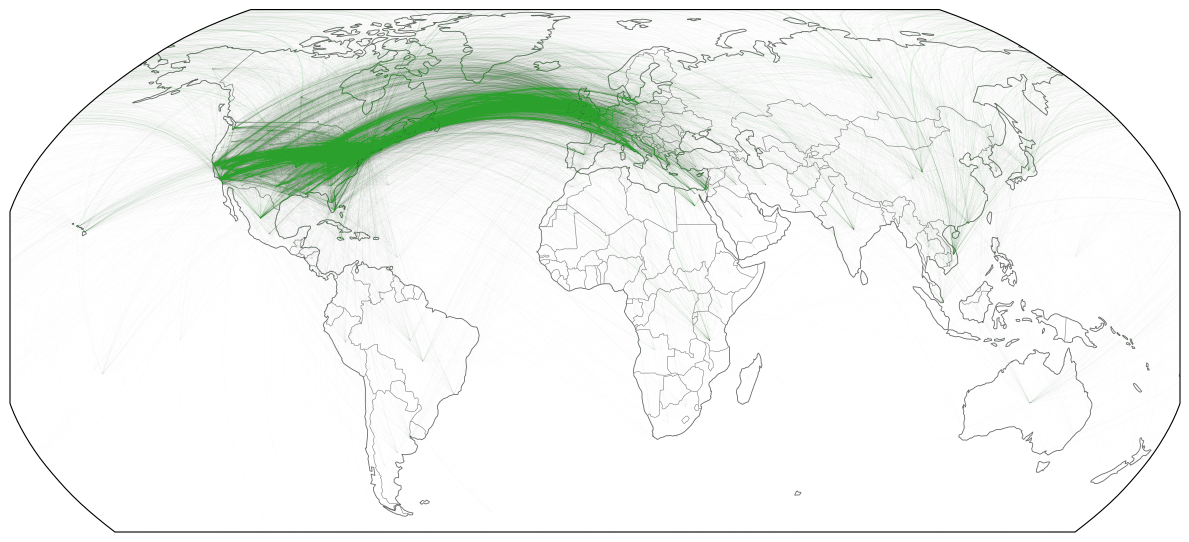

Total hops in conlit: 79899 (from 2754 volumes)


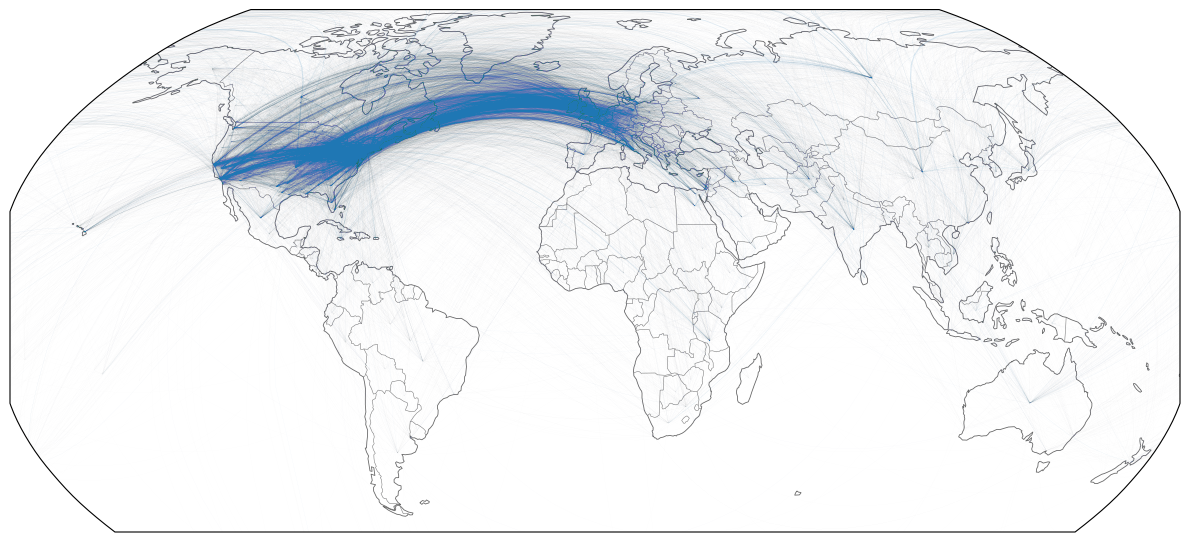

Total hops in eaf: 2275 (from 488 volumes)


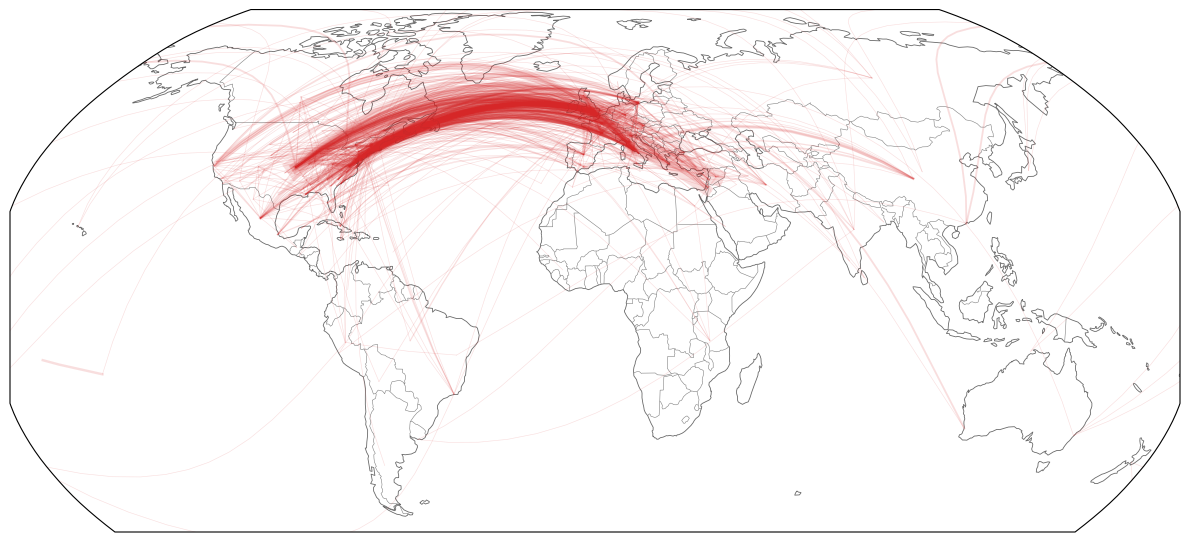

Total hops in wright: 4147 (from 1052 volumes)


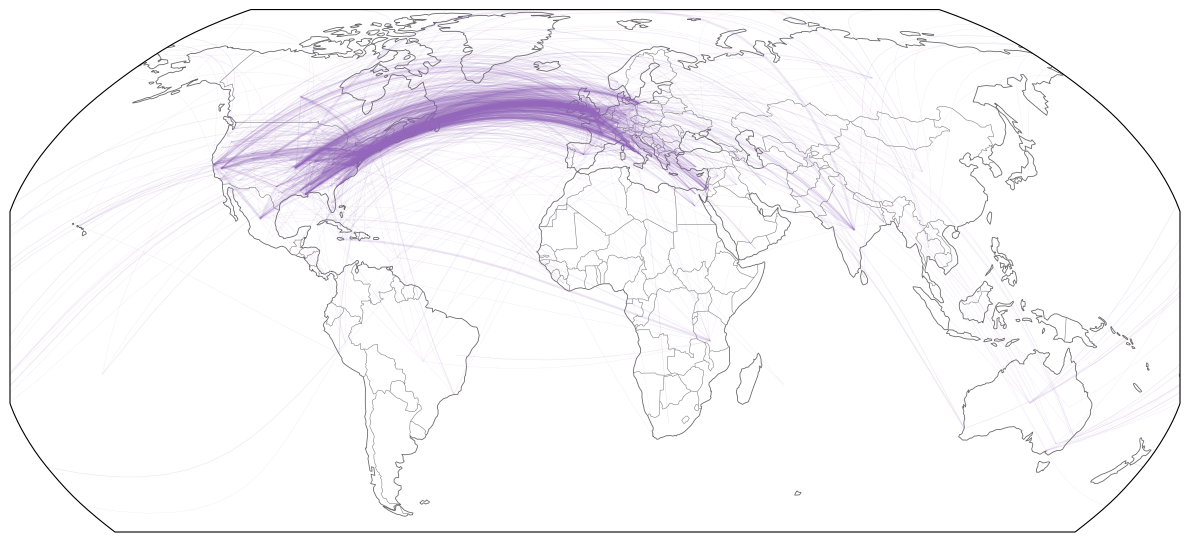

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name, group in data.groupby('collection'):
        # get lat/lon data for all hops in all books
        if name != 'conlit':
            hops = group.gpe_sequences.apply(get_hops, {'geo_data':wie})
        else:
            hops = group.gpe_sequences.apply(get_hops, {'geo_data':wi})
    
        # aggregate hop data
        hops_counter = Counter()
        for book in hops:
            for pair in book:
                hop = sorted(pair)
                hops_counter[tuple(hop)] += 1
        print(f'Total hops in {name}: {hops_counter.total()} (from {len(group)} volumes)')
        
        # map result
        fig = plt.figure(figsize=(12,6))
        ax = plt.axes(projection=ccrs.Robinson())
        ax.set_extent([-175, 175, -60, 85])
        sizefactor = 1000/hops_counter.total()
        for hop in hops_counter:
            plt.plot(
                [i[1] for i in hop],
                [i[0] for i in hop], 
                color=colors[name], 
                marker=None, 
                alpha=map_alpha, 
                linewidth=hops_counter[hop]*sizefactor,
                transform=ccrs.Geodetic()
            )
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
        fig.canvas.draw()
        plt.tight_layout()
        for ext in vis_formats:
            plt.savefig(
                os.path.join(
                    fig_dir, 
                    'maps', 
                    f'world_hop_map_{name}.'+ext
                ), 
                dpi=300
            )
        plt.show()

### By era

In [21]:
era_map = {
    '1865 and earlier': {'dates':   (0,1865), 'color':'wright'},
    '1866-1945':        {'dates':(1866,1945), 'color':'chicago_1'},
    '1946-2000':        {'dates':(1946,2000), 'color':'chicago_2'},
    '2001 and later':   {'dates':(2001,9999), 'color':'conlit'}
}

Total hops in 1865 and earlier: 4213 (from 1100 volumes)


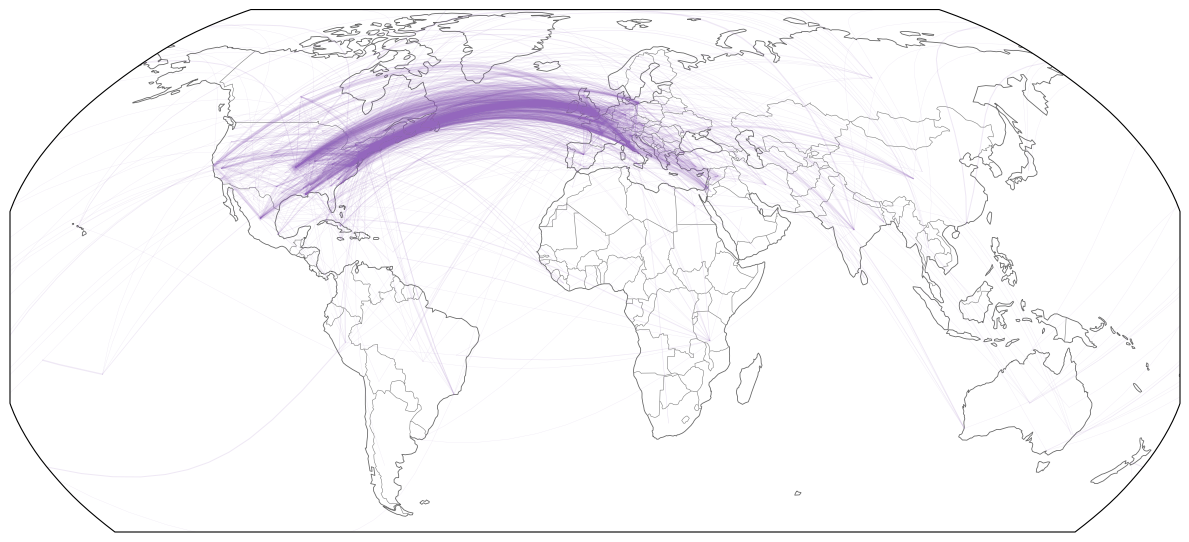

Total hops in 1866-1945: 20803 (from 3048 volumes)


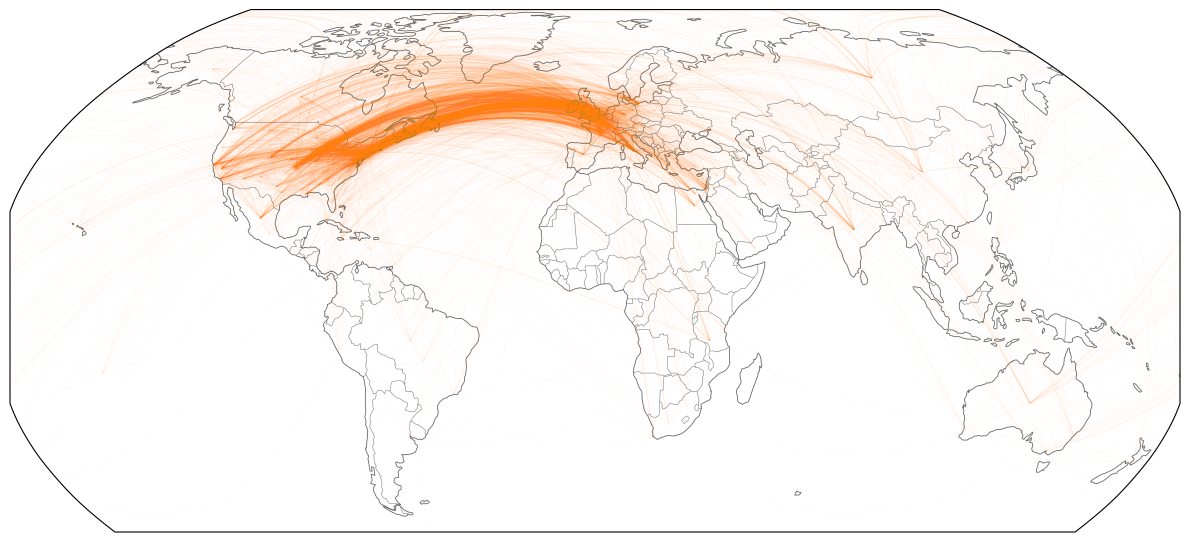

Total hops in 1946-2000: 88565 (from 6481 volumes)


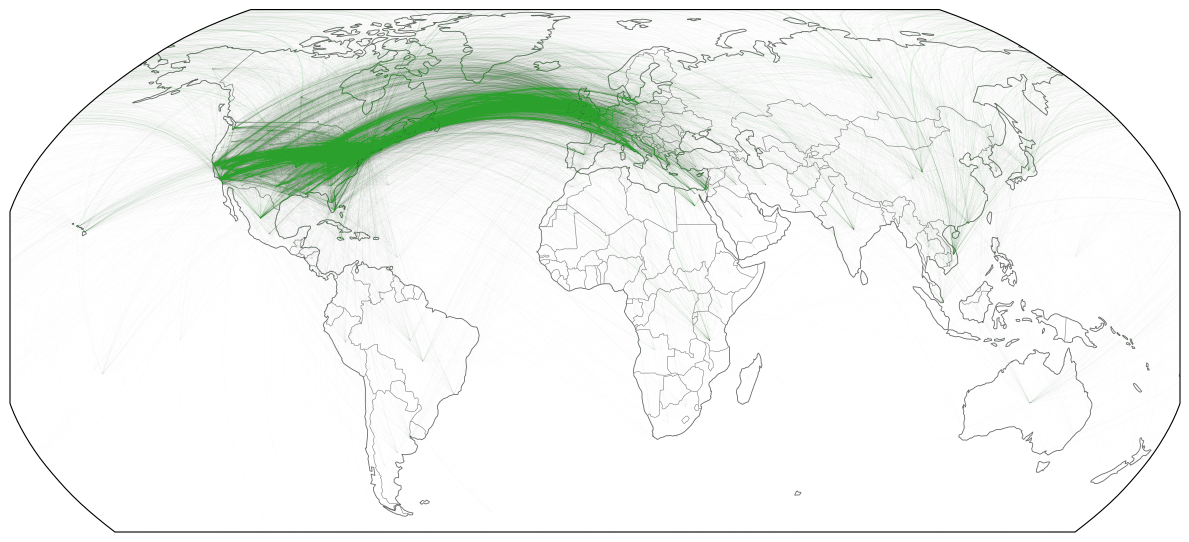

Total hops in 2001 and later: 79899 (from 2754 volumes)


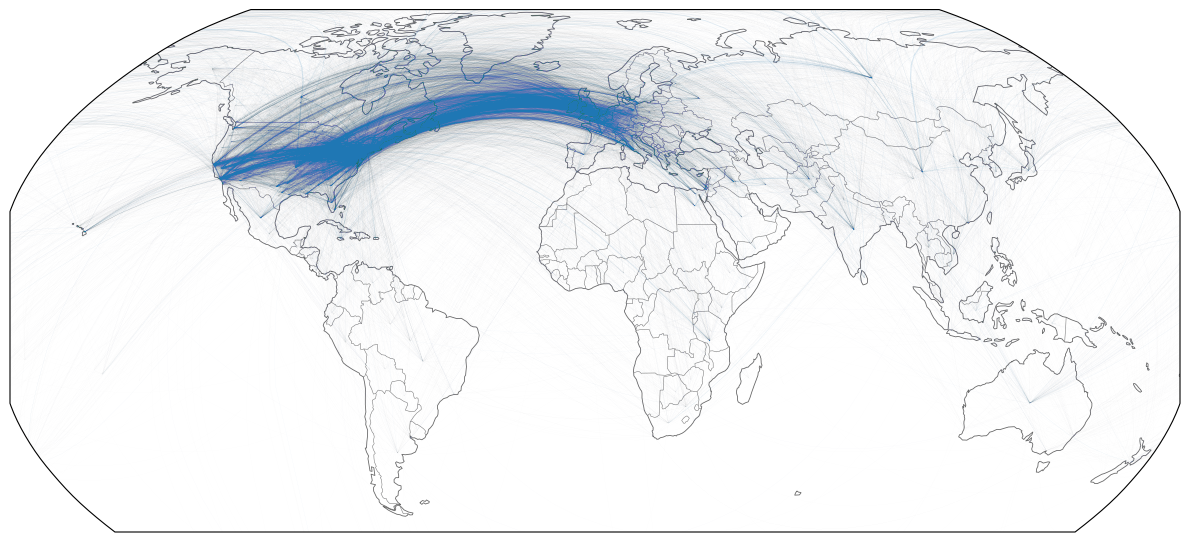

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i, name in enumerate(era_map.keys()):
        df = data.loc[data.pub_date.between(*era_map[name]['dates'])]
        # get lat/lon data for all hops in selected books
        if name != '2001 and later':
            hops = df.gpe_sequences.apply(get_hops, {'geo_data':wie})
        else:
            hops = df.gpe_sequences.apply(get_hops, {'geo_data':wi})
    
        # aggregate hop data
        hops_counter = Counter()
        for book in hops:
            for pair in book:
                hop = sorted(pair)
                hops_counter[tuple(hop)] += 1
        print(f'Total hops in {name}: {hops_counter.total()} (from {len(df)} volumes)')
        
        # map result
        fig = plt.figure(figsize=(12,6))
        ax = plt.axes(projection=ccrs.Robinson())
        ax.set_extent([-175, 175, -60, 85])
        sizefactor = 1000/hops_counter.total()
        for hop in hops_counter:
            plt.plot(
                [i[1] for i in hop],
                [i[0] for i in hop], 
                color=colors[era_map[name]['color']], 
                marker=None, 
                alpha=map_alpha, 
                linewidth=hops_counter[hop]*sizefactor,
                transform=ccrs.Geodetic()
            )
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
        fig.canvas.draw()
        plt.tight_layout()
        for ext in vis_formats:
            plt.savefig(
                os.path.join(
                    fig_dir, 
                    'maps', 
                    f'world_hop_map_{name}.'+ext
                ), 
                dpi=300
            )
        plt.show()

# Fightin' Words

For the method, see [Monroe et al. (2008)](https://languagelog.ldc.upenn.edu/myl/Monroe.pdf). We're using the full-fat version with an informative Dirichlet prior (section 3.5.1, eq. 23).

In [23]:
# functions to display and plot fightinwords results
# FW display output as text
def display_fw(data, n=10, name1='corpus one', name2='corpus two'):
    '''Display the indicated number of top terms from fightinwords output.'''
    print("Top terms in", name1)
    for term, score in reversed(data[-n:]):
        print(f"{term:<15} {score:6.2f}")
    print("")
    print("Top terms in", name2)
    for term, score in data[:n]:
        print(f"{term:<15} {score:6.2f}")

# plot FW results
def plot_fw(
    fw_results, 
    fw_input_array, 
    fw_vocabulary, 
    num_words_to_plot=20,
    label1='Group 1',
    label2='Group 2',
    alpha=0.8,
    name='output',
    print_result=False
):
    
    # convert to dataframe for convenience
    df = pd.DataFrame(fw_input_array, columns=fw_vocabulary)
        
    # manage data for plotting
    frequencies = []
    zscores = []
    words = []
    for word, z_score in fw_results:
        count = df[word].sum()
        if count > 0:
            zscores.append(z_score)
            words.append(word)
            frequencies.append(count)
    
    # plot result
    texts = []
    fig, ax = plt.subplots(1,1)
    
    ax.scatter(
        np.log10(frequencies[-num_words_to_plot:]), 
        zscores[-num_words_to_plot:], 
        alpha=alpha, 
        label=label1
    )
    ax.scatter(
        np.log10(frequencies[:num_words_to_plot]), 
        zscores[:num_words_to_plot], 
        alpha=alpha, 
        label=label2
    )
    
    for i in range(-num_words_to_plot, num_words_to_plot):
        texts.append(ax.text(np.log10(frequencies[i]), zscores[i], words[i], size='small', alpha=0.6))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    plt.xlabel('log(frequency)')
    plt.ylabel('z-score')
    plt.legend()
    plt.tight_layout()
    for ext in vis_formats:
        plt.savefig(
            os.path.join(
                fig_dir, 
                'fightin_words', 
                f'fightinwords_{name}.'+ext
            ), 
            dpi=300
        )
    plt.show()

    if print_result:
        display_fw(fw_results, n=num_words_to_plot, name1=label1, name2=label2)

In [24]:
# function to regularize place data
punctuation_to_space = str.maketrans({key:' ' for key in string.punctuation})
def regularize_string(place_string, remove_stopwords=False):
    temp_tokens = place_string.translate(punctuation_to_space).lower().split()
    if remove_stopwords:
        temp_tokens = [i for i in temp_tokens if i not in ENGLISH_STOP_WORDS]
    if len(temp_tokens) > 0:
        return(unidecode(' '.join(temp_tokens)))
    else:
        return('')

In [25]:
# GPEs
cv = CountVectorizer(
    tokenizer=lambda x: x, 
    token_pattern=None,
    preprocessor=lambda x: [regularize_string(i) for i in x],
    min_df=20
)
gpe_array = cv.fit_transform(data.gpe_places).toarray()
gpe_prior = gpe_array.sum(axis=0)
print(f'Number of GPE features: {len(cv.get_feature_names_out())}')

Number of GPE features: 915


In [26]:
# top GPEs
for idx in gpe_prior.argsort()[::-1][:20]:
    print(f'{cv.get_feature_names_out()[idx]:<15} {gpe_prior[idx]:>6.0f}')

new york         21694
london           12956
paris            11260
america           9291
england           7701
chicago           6802
california        6237
boston            5616
washington        5565
france            4882
rome              4381
san francisco     4196
texas             3088
los angeles       3040
virginia          2982
mexico            2814
europe            2594
florida           2380
new orleans       2289
manhattan         2244


In [27]:
# Non-GPEs
cv_non = CountVectorizer(
    tokenizer=lambda x: x, 
    token_pattern=None,
    preprocessor=lambda x: [regularize_string(i, remove_stopwords=True) for i in x],
    stop_words=[''],
    min_df=20
)
nongpe_array = cv_non.fit_transform(data.nongpe_places).toarray()
nongpe_prior = nongpe_array.sum(axis=0)
print(f'Number of non-GPE features: {len(cv_non.get_feature_names_out())}')

Number of non-GPE features: 3006


In [28]:
# top generics
for idx in nongpe_prior.argsort()[::-1][:20]:
    print(f'{cv_non.get_feature_names_out()[idx]:<15} {nongpe_prior[idx]:>6.0f}')

room            233877
house           173925
home            113500
place            50297
office           48699
kitchen          40523
apartment        34006
street           33808
bedroom          24768
hall             23191
road             23041
school           22938
living room      16251
cabin            14536
porch            13912
hospital         13499
building         12966
yard             12241
beach            10932
camp             10721



Comparing GPEs in CONLIT Fiction vs. CONLIT Nonfiction
Vocab size is 915
Comparing language...


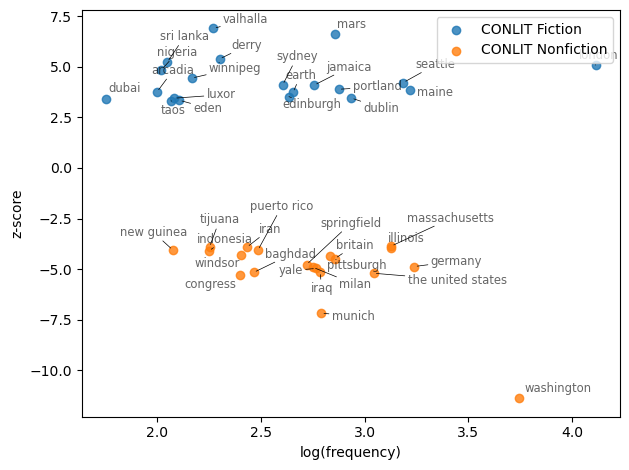

Top terms in CONLIT Fiction
valhalla          6.89
mars              6.60
derry             5.38
sri lanka         5.22
london            5.08
nigeria           4.85
winnipeg          4.44
seattle           4.22
sydney            4.10
jamaica           4.09
portland          3.89
maine             3.84
arcadia           3.76
earth             3.73
edinburgh         3.52
dublin            3.45
luxor             3.44
dubai             3.43
eden              3.34
taos              3.32

Top terms in CONLIT Nonfiction
washington      -11.37
munich           -7.17
congress         -5.30
the united states  -5.20
baghdad          -5.16
iraq             -5.13
yale             -4.96
milan            -4.90
germany          -4.87
springfield      -4.77
britain          -4.47
pittsburgh       -4.36
windsor          -4.30
indonesia        -4.09
puerto rico      -4.06
new guinea       -4.05
illinois         -3.97
iran             -3.91
tijuana          -3.91
massachusetts    -3.86

Comparing non-GPE

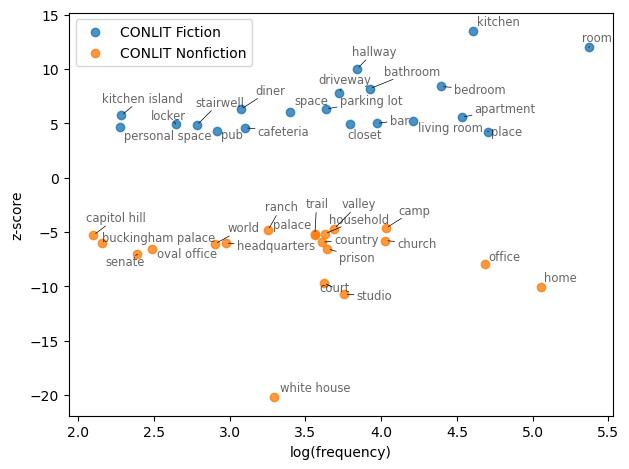

Top terms in CONLIT Fiction
kitchen          13.51
room             11.98
hallway          10.00
bedroom           8.39
bathroom          8.19
driveway          7.77
parking lot       6.31
diner             6.29
space             6.04
kitchen island    5.74
apartment         5.56
living room       5.25
bar               4.98
locker            4.93
closet            4.90
stairwell         4.81
personal space    4.63
cafeteria         4.59
pub               4.26
place             4.23

Top terms in CONLIT Nonfiction
white house     -20.23
studio          -10.72
home            -10.07
court            -9.70
office           -7.99
senate           -7.05
oval office      -6.55
prison           -6.55
world            -6.09
headquarters     -6.02
buckingham palace  -6.00
country          -5.94
church           -5.80
capitol hill     -5.31
trail            -5.24
palace           -5.20
household        -5.17
ranch            -4.84
valley           -4.70
camp             -4.66

Comparing GPEs in

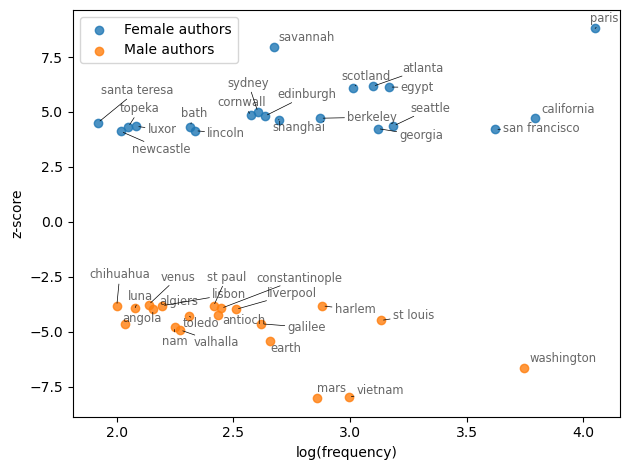

Top terms in Female authors
paris             8.80
savannah          7.94
atlanta           6.16
egypt             6.13
scotland          6.11
sydney            5.00
cornwall          4.84
edinburgh         4.82
california        4.72
berkeley          4.72
shanghai          4.65
santa teresa      4.51
seattle           4.36
luxor             4.35
bath              4.34
topeka            4.32
georgia           4.25
san francisco     4.21
lincoln           4.15
newcastle         4.12

Top terms in Male authors
mars             -8.02
vietnam          -7.98
washington       -6.63
earth            -5.44
valhalla         -4.92
nam              -4.77
angola           -4.66
galilee          -4.64
st louis         -4.49
toledo           -4.30
antioch          -4.22
liverpool        -3.98
algiers          -3.94
constantinople   -3.94
luna             -3.90
st paul          -3.84
chihuahua        -3.83
harlem           -3.82
lisbon           -3.82
venus            -3.77

Comparing non-GPEs in Fe

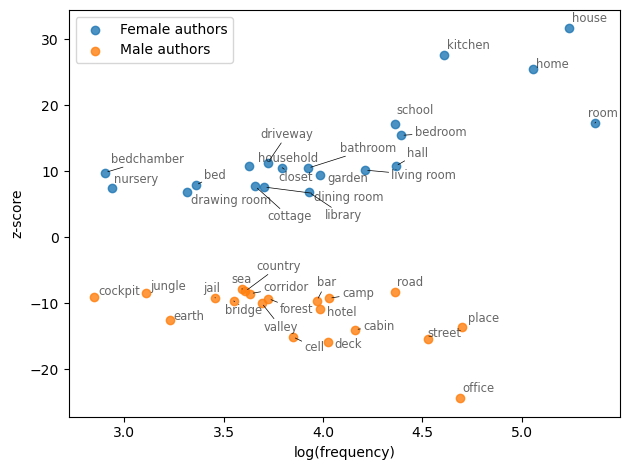

Top terms in Female authors
house            31.64
kitchen          27.64
home             25.56
room             17.30
school           17.23
bedroom          15.43
driveway         11.32
household        10.77
hall             10.76
closet           10.52
bathroom         10.47
living room      10.17
bedchamber        9.79
garden            9.37
bed               7.88
cottage           7.71
dining room       7.60
nursery           7.40
drawing room      6.84
library           6.79

Top terms in Male authors
office          -24.43
deck            -15.96
street          -15.42
cell            -15.11
cabin           -14.02
place           -13.69
earth           -12.62
hotel           -10.93
valley          -10.00
bridge           -9.68
bar              -9.62
forest           -9.33
camp             -9.28
jail             -9.22
cockpit          -9.15
corridor         -8.57
jungle           -8.43
road             -8.32
country          -8.22
sea              -7.90

Comparing GPEs in she/he

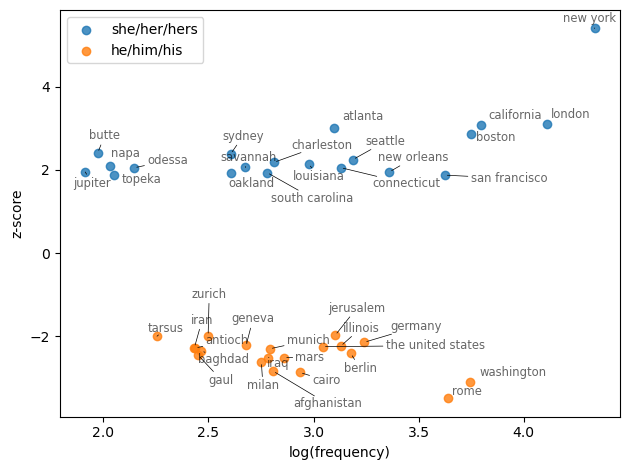

Top terms in she/her/hers
new york          5.39
london            3.11
california        3.07
atlanta           2.99
boston            2.86
butte             2.41
sydney            2.38
seattle           2.25
charleston        2.18
louisiana         2.14
napa              2.10
savannah          2.06
connecticut       2.05
odessa            2.05
jupiter           1.95
new orleans       1.95
south carolina    1.94
oakland           1.91
san francisco     1.87
topeka            1.87

Top terms in he/him/his
rome             -3.48
washington       -3.10
cairo            -2.87
afghanistan      -2.83
milan            -2.61
iraq             -2.52
mars             -2.51
gaul             -2.45
berlin           -2.41
baghdad          -2.34
munich           -2.30
antioch          -2.28
iran             -2.27
the united states  -2.25
illinois         -2.23
geneva           -2.21
germany          -2.14
tarsus           -2.00
zurich           -1.99
jerusalem        -1.97

Comparing non-GPEs in she/

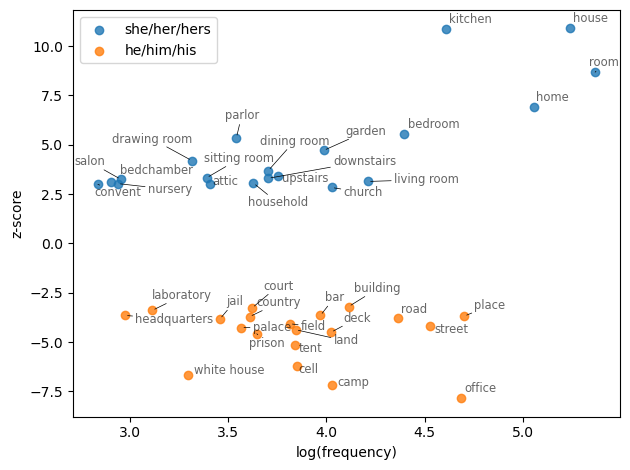

Top terms in she/her/hers
house            10.89
kitchen          10.86
room              8.67
home              6.90
bedroom           5.53
parlor            5.35
garden            4.71
drawing room      4.19
dining room       3.69
upstairs          3.41
sitting room      3.32
downstairs        3.30
salon             3.25
living room       3.14
bedchamber        3.11
household         3.06
attic             3.03
nursery           3.03
convent           2.99
church            2.83

Top terms in he/him/his
office           -7.85
camp             -7.19
white house      -6.67
cell             -6.23
tent             -5.15
prison           -4.58
deck             -4.51
land             -4.37
palace           -4.27
street           -4.17
field            -4.07
jail             -3.83
road             -3.79
country          -3.72
place            -3.69
bar              -3.65
headquarters     -3.65
laboratory       -3.40
court            -3.27
building         -3.20

Comparing GPEs in First-pers

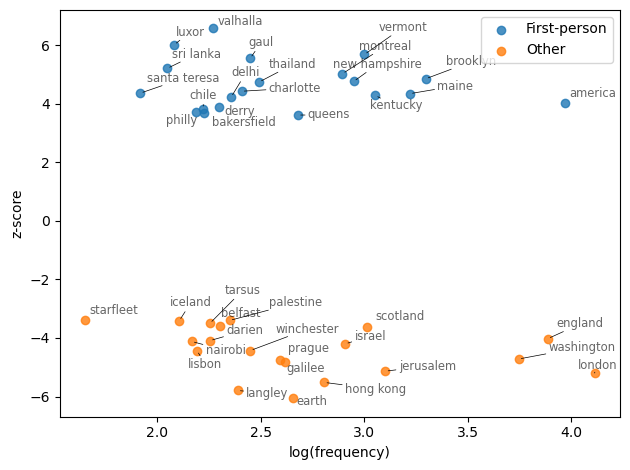

Top terms in First-person
valhalla          6.56
luxor             6.01
vermont           5.68
gaul              5.55
sri lanka         5.20
montreal          5.02
brooklyn          4.85
new hampshire     4.76
thailand          4.74
charlotte         4.42
santa teresa      4.36
maine             4.34
kentucky          4.28
delhi             4.22
america           4.02
derry             3.88
chile             3.82
philly            3.70
bakersfield       3.69
queens            3.61

Top terms in Other
earth            -6.06
langley          -5.79
hong kong        -5.52
london           -5.20
jerusalem        -5.13
galilee          -4.82
prague           -4.75
washington       -4.72
lisbon           -4.44
winchester       -4.43
israel           -4.20
nairobi          -4.12
darien           -4.09
england          -4.03
scotland         -3.63
belfast          -3.60
tarsus           -3.50
iceland          -3.41
palestine        -3.40
starfleet        -3.39

Comparing non-GPEs in First-perso

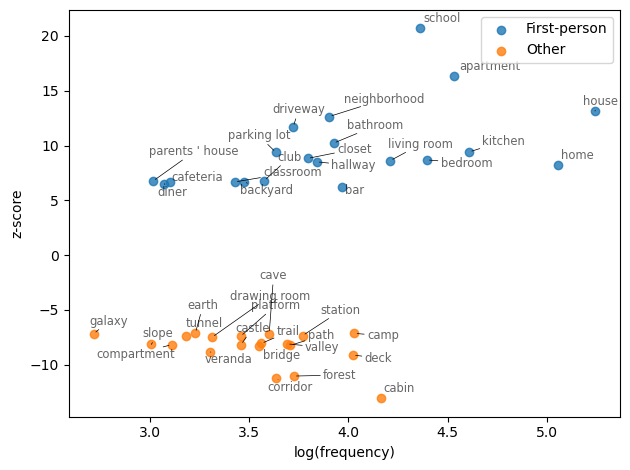

Top terms in First-person
school           20.69
apartment        16.33
house            13.15
neighborhood     12.65
driveway         11.70
bathroom         10.22
kitchen           9.42
parking lot       9.38
closet            8.82
bedroom           8.69
living room       8.63
hallway           8.52
home              8.19
club              6.80
parents ' house   6.76
backyard          6.70
classroom         6.68
cafeteria         6.67
diner             6.51
bar               6.26

Top terms in Other
cabin           -13.06
corridor        -11.21
forest          -11.04
deck             -9.11
veranda          -8.84
bridge           -8.32
path             -8.24
castle           -8.18
compartment      -8.18
slope            -8.15
valley           -8.10
trail            -8.06
drawing room     -7.49
platform         -7.41
tunnel           -7.36
station          -7.35
galaxy           -7.18
cave             -7.17
camp             -7.14
earth            -7.10


In [30]:
fw_tests = {
    'conlit_fic_nonfic':{
        'g1':{
            'selector':(data.Category=='FIC') & (data.collection=='conlit'),
            'label':'CONLIT Fiction'
        },
        'g2':{
            'selector':(data.Category=='NON') & (data.collection=='conlit'),
            'label':'CONLIT Nonfiction'
        }
    },
    'all_fiction_author_gender':{
        'g1':{
            'selector':(data.author_gender=='F') & (data.Category=='FIC'),
            'label':'Female authors'
        },
        'g2':{
            'selector':(data.author_gender=='M') & (data.Category=='FIC'),
            'label':'Male authors'
        }
    },
    'all_fiction_character_gender':{
        'g1':{
            'selector':(data.inf_gender=='she/her/hers') & (data.Category=='FIC'),
            'label':'she/her/hers'
        },
        'g2':{
            'selector':(data.author_gender=='he/him/his') & (data.Category=='FIC'),
            'label':'he/him/his'
        }
    },
    'all_fiction_perspective':{
        'g1':{
            'selector':(data.perspective=='first') & (data.Category=='FIC'),
            'label':'First-person'
        },
        'g2':{
            'selector':(data.perspective=='other') & (data.Category=='FIC'),
            'label':'Other'
        }
    },
}

for test in fw_tests:
    # GPEs
    print(f"\n==============\nComparing GPEs in {fw_tests[test]['g1']['label']} vs. {fw_tests[test]['g2']['label']}\n==============")
    fw_result = fw.bayes_compare_language(
        l1=np.where(fw_tests[test]['g1']['selector'])[0], 
        l2=np.where(fw_tests[test]['g2']['selector'])[0], 
        features=gpe_array,
        prior=gpe_prior,
        cv=cv
    )
    plot_fw(
        fw_result, 
        gpe_array, 
        cv.get_feature_names_out(),
        label1=fw_tests[test]['g1']['label'],
        label2=fw_tests[test]['g2']['label'],
        name=test+'_gpes',
        print_result=True
    )

    #Non-GPEs
    print(f"\n==============\nComparing non-GPEs in {fw_tests[test]['g1']['label']} vs. {fw_tests[test]['g2']['label']}\n==============")
    fw_result = fw.bayes_compare_language(
        l1=np.where(fw_tests[test]['g1']['selector'])[0], 
        l2=np.where(fw_tests[test]['g2']['selector'])[0], 
        features=nongpe_array,
        prior=nongpe_prior,
        cv=cv_non
    )
    plot_fw(
        fw_result, 
        nongpe_array, 
        cv_non.get_feature_names_out(),
        label1=fw_tests[test]['g1']['label'],
        label2=fw_tests[test]['g2']['label'],
        name=test+'_nongpes',
        print_result=True
    )